# Coding Assignment 1: Music Auto-tagging Model
- In this assignment, you will train your auto-tagging model using PyTorch
- The dataset is from MagnaTagATune
  - Randomly selected 8000 mp3 files
  - 5000 files for training, 1000 for validation, 2000 for test
  
- Every code cell before the Problem 0 has to be ran without modification or error
- You have to submit three files:
  - Report in PDF (free format)
      - Explain what you have tried and what you have got as the result
      - Your submission would be evaluated mainly with the report
  - Notebook in ipynb
  - Audio data that you used for Problem 5
 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
DEV = 'cuda'

## 0. Import Library

In [3]:
!pip install torchaudio==0.9.0
import torch
import torch.nn as nn
import torchaudio
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import IPython.display as ipd
import time

In [4]:
SAVE_TYP = 'google_drive'

if SAVE_TYP == 'local': # if you selected to save it in local
  from google.colab import files
else:
  from google.colab import drive # if you selected to save it in your Google Drive
  drive.mount('/content/drive')
  GGL_DIR = Path('/content/drive/MyDrive/Creative_Tech_Assignment1/')
  GGL_DIR.mkdir(exist_ok=True)

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

MTAT_DIR = Path('/content/drive/MyDrive/Creative_Tech_Assignment1/MTAT_SMALL/')
if IN_COLAB and SAVE_TYP=="google_drive":
  PLOT_DIR = GGL_DIR / "plots/"
else:
  PLOT_DIR = Path('plots/')
PLOT_DIR.mkdir(exist_ok=True)

def save_fig_with_date(figname):
  plt.savefig(PLOT_DIR/f"{figname}_{'_'.join(time.ctime().split(' ')[1:4])}.png")

def file_name_with_date(filename):
  filename = Path(filename)
  return f"{filename.stem}_{'_'.join(time.ctime().split(' ')[1:4])}{filename.suffix}"

def save_file(fn):
  if IN_COLAB: # If you are running this notebook on Colab 
    if SAVE_TYP == 'local': # if you selected to save it in local
      files.download(fn)   # download the file to your local computer 
    else:
      shutil.copy(fn, GGL_DIR)  # copy the file to your google drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- Download dataset from Google Drive link and Unzip at `MTAT_SMALL/`

In [ ]:
!rm -rf /content/MTAT_SMALL
!gdown --id 15e9E3oZdudErkPKwb0rCAiZXkPxdZkV6
!unzip -q mtat_8000.zip -d /content/drive/MyDrive/Creative_Tech_Assignment1

  0%|          | 3/4000 [00:54<20:07:52, 18.13s/it]


Downloading...
From: https://drive.google.com/uc?id=15e9E3oZdudErkPKwb0rCAiZXkPxdZkV6
To: /content/mtat_8000.zip
100% 921M/921M [00:10<00:00, 87.6MB/s]


## 1. Prepare Dataset
- You can use the pre-processed data

In [5]:
class MTATDataset:
  def __init__(self, dir, split='train', num_max_data=4000):
    self.dir = dir
    self.labels = pd.read_csv(dir / "meta.csv", index_col=[0])
    self.sr = 16000

    if split=="train":
      sub_dir_ids = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c']
    elif split=='valid':
      sub_dir_ids = ['d']
    else: #test
      sub_dir_ids = ['e', 'f', 'g']

    is_in_set = [True if x[0] in sub_dir_ids else False for x in self.labels['mp3_path'].values.astype('str')]
    self.labels = self.labels.iloc[is_in_set]
    self.labels = self.labels[:num_max_data]

    self.vocab = self.labels.columns.values[1:-1]
    self.audios = self.load_audio_dataset()
    self.label_tensor = self.convert_label_to_tensor()
    
  def load_audio_dataset(self):
    return [self.load_audio_and_resample(self.dir/x) for x in tqdm(self.labels['mp3_path'].values)]

  def load_audio_and_resample(self, audio_path):
    audio, sr = torchaudio.load(audio_path)
    resampled_audio = torchaudio.functional.resample(audio, orig_freq=sr, new_freq=self.sr)
    return resampled_audio.squeeze()

  def convert_label_to_tensor(self):
    return torch.LongTensor(self.labels.values[:, 1:-1].astype('bool'))

  def __getitem__(self, idx):
    audio = self.audios[idx]
    tag = self.label_tensor[idx]
    return audio, tag

  def __len__(self):
    return len(self.labels)

data_dir = MTAT_DIR
trainset = MTATDataset(data_dir, split='train', num_max_data=4000)
validset = MTATDataset(data_dir, split='valid')
#testset = MTATDataset(data_dir, split='test')

100%|██████████| 1000/1000 [06:56<00:00,  2.40it/s]


- Define `DataLoader` using the dataset

In [6]:
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
valid_loader = DataLoader(validset, batch_size=128, shuffle=False)
# test_loader = DataLoader(testset,batch_size=128, shuffle=False)

## 2. Define Neural Network
- Define the neural network

In [7]:
from torchsummary import summary

class SpecModel(nn.Module):
  def __init__(self, sr, n_fft, hop_length, n_mels):
    super().__init__()
    self.mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    self.db_converter = torchaudio.transforms.AmplitudeToDB()
  
  def forward(self, x):
    mel_spec = self.mel_converter(x)
    return self.db_converter(mel_spec)

class AudioModel(nn.Module):
  def __init__(self, sr, n_fft, hop_length, n_mels, hidden_size, num_output):
    super().__init__()
    self.sr = sr
    self.spec_converter = SpecModel(sr, n_fft, hop_length, n_mels)
    self.conv_layer = nn.Sequential(
      nn.Conv1d(n_mels, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),
      nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),     
      nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),
    )
    self.final_layer = nn.Linear(hidden_size, num_output)

  def get_spec(self, x):
    '''
    Get result of self.spec_converter
    x (torch.Tensor): audio samples (num_batch_size X num_audio_samples)
    '''
    return self.spec_converter(x)
  
  def forward(self, x):
    spec = self.get_spec(x) # num_batch X num_mel_bins X num_time_bins
    out = self.conv_layer(spec)
    out = torch.max(out, dim=-1)[0] # select [0] because torch.max outputs tuple of (value, index)
    out = self.final_layer(out)
    out = torch.sigmoid(out)
    return out


## 3. Train the Network
- First, just run the cells below so that you can obtain the first result


In [8]:
def get_tpr_fnr(pred, target, threshold=0.5):
  thresh_pred = pred> threshold
  p = torch.sum(target == 1)
  tp = torch.sum((thresh_pred==1) * (target==1))
  n = torch.sum(target == 0)
  fn = torch.sum((thresh_pred==1) * (target==0))
  return tp/p, fn/n

def get_roc_auc(pred, label, num_grid=500):
  auc = 0
  prev_fpr = 0
  for thresh in reversed(torch.linspace(0,1,num_grid)):
    tpr, fpr = get_tpr_fnr(pred, label, threshold=thresh)
    auc += tpr * (fpr-prev_fpr)
    prev_fpr = fpr
  return auc

def train_model(model, train_loader, valid_loader, optimizer, num_epochs, loss_func, device='cuda'):
  loss_records =[] 
  valid_acc_records = []
  model.vocab = train_loader.dataset.vocab
  model.train() # Set model to train mode
  best_valid_acc = 0.0
  for epoch in range(num_epochs):
    pbar = tqdm(enumerate(train_loader), total = len(train_loader))
    for idx, batch in pbar:
      optimizer.zero_grad() # Rest gradient of every parameters in optimizer (every parameters in the model)
      audio, label = batch
      audio = audio.to(device)
      label = label.to(device)
      pred = model(audio)
      loss = loss_func(pred, label.float())
      loss.backward() # Run backpropagation
      optimizer.step() # Update parameters
      loss_records.append(loss.item())
      
      description = f"Epoch : {epoch} , loss : {loss.item():.4f}"
      pbar.set_description(description)    

    valid_acc = validate_model(model, valid_loader, device)
    valid_acc_records.append(valid_acc.item())
    
    if best_valid_acc < valid_acc:
      best_valid_acc = valid_acc

  print(f'Best Valid Accuracy is {best_valid_acc:.4f}')
  return {"loss": loss_records, "valid_acc": valid_acc_records}

def validate_model(model, valid_loader, device, acc_func=get_roc_auc):
  valid_acc = 0
  model.eval()
  with torch.no_grad():
    for batch in valid_loader:
      audio, label = batch
      pred = model(audio.to(device))
      auc = acc_func(pred, label.to(device))
      valid_acc += auc * len(label)
  model.train()
  return valid_acc / len(valid_loader.dataset)

In [9]:
model = AudioModel(sr=16000, n_fft=1024, hop_length=512, n_mels=48, num_output=50, hidden_size=32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model = model.to(DEV)
loss_func = torch.nn.BCELoss()
train_record = train_model(model, train_loader, valid_loader, optimizer, num_epochs=30, loss_func=loss_func, device=DEV)

  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
Epoch : 29 , loss : 0.1302: 100%|██████████| 63/63 [00:07<00:00,  8.85it/s]


Best Valid Accuracy is 0.8804


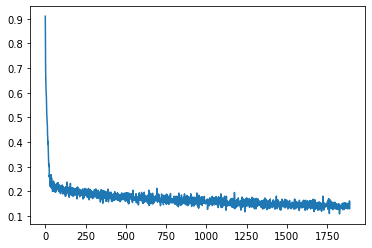

In [10]:
plt.plot(train_record['loss'])
save_fig_with_date('default_train_loss')

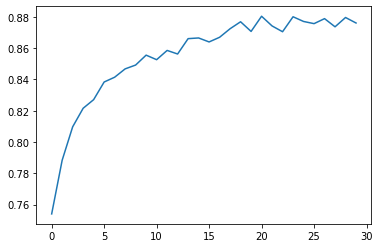

In [11]:
plt.plot(train_record['valid_acc'])
save_fig_with_date('default_train_valid_acc')

### Problem 0. Practice with nn.Sequential() (10 pts)
- `nn.Sequential` automatically stacks the `nn.Module`
    - If `x = nn.Sequential( nn.Conv1d(48, 12) , nn.ReLU() )`,
        - `out = x(input)` is same with `out` below
        - `x1 = nn.Conv1d(48,12)`, `x2=nn.ReLU()`, `out = x2(x1(input))`


In [12]:
class StackManualLayer(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Conv1d(16, 4, kernel_size=2)
    self.activation = nn.Sigmoid()
    self.layer2 = nn.Conv1d(4, 4, kernel_size=2)
    self.layer3 = nn.Conv1d(4, 1, kernel_size=2)
    
  def forward(self, x):
    out = self.layer1(x)
    out = self.activation(out)
    out = self.layer2(out)
    out = self.activation(out)
    out = self.layer3(out)
    return out

class SequentialLayer(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      #TODO: Complete this nn.Sequential so that it computes exactly same thing with StackManualLayer
      nn.Conv1d(16, 4, kernel_size = 2),
      nn.Sigmoid(),
      nn.Conv1d(4, 4, kernel_size = 2),
      nn.Sigmoid(),
      nn.Conv1d(4, 1, kernel_size = 2),
    )
  def forward(self, x):
    out = self.layers(x)
    return out
  
# Do not change the code below
torch.manual_seed(0)
manual_layer = StackManualLayer()
torch.manual_seed(0)
sequential_layer = SequentialLayer()

test_dummy = torch.arange(128).view(1,16,8).float()
manual_out = manual_layer(test_dummy)
print(f"Output with Manual Stack Layer: {manual_out}")
sequential_out = sequential_layer(test_dummy)
print(f"Output with Sequential Layer: {sequential_out}")

# The printed result has to be same


Output with Manual Stack Layer: tensor([[[0.0241, 0.0263, 0.0280, 0.0291, 0.0300]]],
       grad_fn=<SqueezeBackward1>)
Output with Sequential Layer: tensor([[[0.0241, 0.0263, 0.0280, 0.0291, 0.0300]]],
       grad_fn=<SqueezeBackward1>)


### Problem 1. Make Your Own Conv Layers (10 pts)
- Complete the `self.conv_layer` of `YourModel`
      

In [13]:
class YourModel(AudioModel):
  def __init__(self, sr, n_fft, hop_length, n_mels, hidden_size, num_output):
    super().__init__(sr, n_fft, hop_length, n_mels, hidden_size, num_output)
    self.sr = sr
    self.spec_converter = SpecModel(sr, n_fft, hop_length, n_mels)

    '''
      TODO: Complete your new conv layer =
      Example:
      self.conv_layer = nn.Sequential(
        nn.Conv1d(n_mels, out_channels=hidden_size, kernel_size=3),
        nn.MaxPool1d(3),
        nn.ReLU(),
        nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
        nn.MaxPool1d(3),
        nn.ReLU()
    )
      '''
    self.conv_layer = nn.Sequential(
        nn.Conv1d(n_mels, hidden_size, kernel_size = 3),
        nn.MaxPool1d(3),
        nn.BatchNorm1d(hidden_size),
        nn.ReLU(),
        nn.Conv1d(hidden_size, 32, kernel_size = 3),
        nn.MaxPool1d(3),
        nn.BatchNorm1d(32),
        nn.ReLU(),
        nn.Conv1d(32, 16, kernel_size = 3),
        nn.MaxPool1d(3),
        nn.BatchNorm1d(16),
        nn.ReLU(),
    )
    self.final_layer = nn.Linear(16, num_output)

  def get_spec(self, x):
    return self.spec_converter(x)

  def forward(self, x):
    
    x = self.get_spec(x)
    out = self.conv_layer(x)
    out = torch.max(out, dim=-1)[0] # select [0] because torch.max outputs tuple of (value, index)
    out = self.final_layer(out)
    out = torch.sigmoid(out)
    return out


In [14]:
your_model = YourModel(sr=16000, n_fft=1024, hop_length=512, n_mels=128, num_output=50, hidden_size=64)
optimizer = torch.optim.Adam(your_model.parameters(), lr=1e-3)
your_model = your_model.to(DEV)
your_train_record = train_model(your_model, train_loader, valid_loader, optimizer, num_epochs=30, loss_func=loss_func, device=DEV)

Epoch : 29 , loss : 0.1670: 100%|██████████| 63/63 [00:07<00:00,  8.55it/s]


Best Valid Accuracy is 0.8717


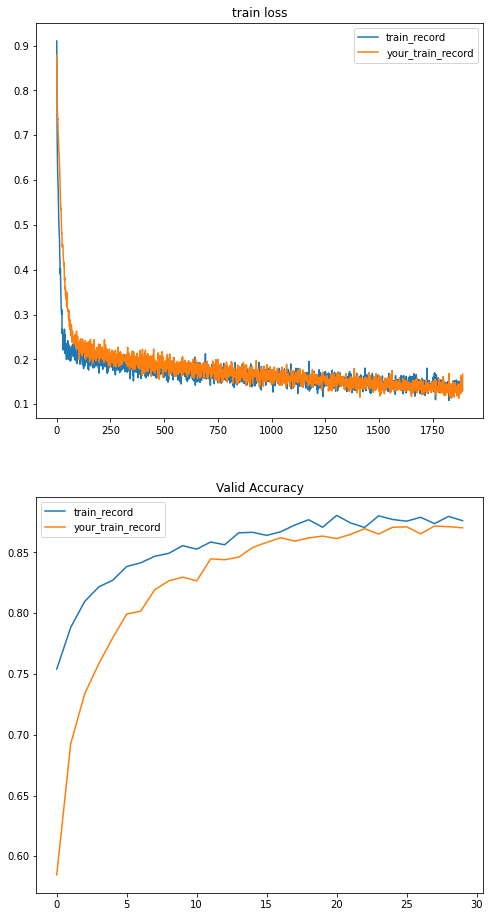

In [15]:
plt.figure(figsize=(8,16))
#train loss
plt.subplot(2,1,1)
plt.title("train loss")
plt.plot(train_record['loss'], label = "train_record" )
plt.plot(your_train_record['loss'], label = "your_train_record" )
plt.legend()


#valid loss
plt.subplot(2,1,2)
plt.title("Valid Accuracy")
plt.plot(train_record['valid_acc'], label = "train_record")
plt.plot(your_train_record['valid_acc'], label = "your_train_record")
plt.legend()

save_fig_with_date('comparison_with_default')

### Probelm 2. Try Various Settings and Report (40 pts)
- You can try different `n_fft`, `n_mels`, or `hidden_size`, or different `conv_layer` in your model

In [28]:
your_model = YourModel(sr=16000, n_fft=1024, hop_length=512, n_mels=128, num_output=50, hidden_size=64)
optimizer = torch.optim.Adam(your_model.parameters(), lr=1e-3)
your_model = your_model.to(DEV)
your_train_record = train_model(your_model, train_loader, valid_loader, optimizer, num_epochs=30, loss_func=loss_func, device=DEV)

Epoch : 29 , loss : 0.1198: 100%|██████████| 63/63 [00:07<00:00,  8.78it/s]


Best Valid Accuracy is 0.8819


### Problem 3 Complete Binary Cross Entropy Function (10 pts) 
- Complete the function that can calculate the Binary Cross Entropy for given prediction and target label without using `torch.BCELoss`
- ![bce](https://androidkt.com/wp-content/uploads/2021/05/Selection_099.png)

Epoch : 4 , loss : 9.6341: 100%|██████████| 63/63 [00:06<00:00,  9.22it/s]


Best Valid Accuracy is 0.8339


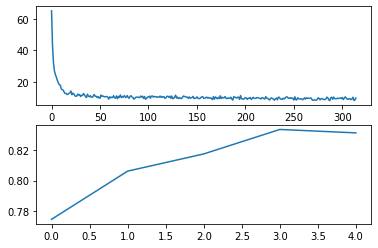

In [18]:
def get_binary_cross_entropy(pred:torch.Tensor, target:torch.Tensor):
  '''
  pred (torch.Tensor): predicted value of a neural network model for a given input (assume that the value is output of sigmoid function)
  target (torch.Tensor): ground-truth label for a given input, given in multi-hot encoding

  output (torch.Tensor): Binary Cross Entropy Loss value with shape of (1)
  '''
  # TODO: Complete this function
  bce = torch.sum(-target * torch.log(pred) - (1-target)*torch.log(1-pred)) / pred.shape[0]
  return bce 

test_model = AudioModel(sr=16000, n_fft=1024, hop_length=512, n_mels=128, num_output=50, hidden_size=64)
test_model = test_model.to(DEV)
test_optimizer = torch.optim.Adam(test_model.parameters(), lr=1e-3)
train_record = train_model(test_model, train_loader, valid_loader, test_optimizer, num_epochs=5, loss_func=get_binary_cross_entropy, device=DEV)
plt.subplot(2,1,1)
plt.plot(train_record['loss'])
plt.subplot(2,1,2)
plt.plot(train_record['valid_acc'])
save_fig_with_date('handmade_bce_result')

### Problem 4. Complete Precision-Recall Area Under Curve Function (10 pts)
- You can refer the pre-defined `get_roc_auc` function

In [29]:
#testset = MTATDataset(data_dir, split='test')
#test_loader = DataLoader(testset,batch_size=64, shuffle=False)
import numpy as np
def get_precision_recall_auc(pred:torch.Tensor, target:torch.Tensor, num_grid=500):
  '''
  pred (torch.Tensor): predicted value of a neural network model for a given input 
  target (torch.Tensor): ground-truth label for a given input, given in multi-hot encoding

  output (torch.Tensor): Area Under Curve value for Precision-Recall Curve
  '''
  # TODO: Complete This Function
  output = get_roc_auc(pred, target, num_grid=500)
  return output

  

selected_model = model
pr_auc_value = validate_model(selected_model, valid_loader, DEV, acc_func=get_precision_recall_auc)
print(f"Calculated PR_AUC value is : {pr_auc_value}")

Calculated PR_AUC value is : 0.8760897517204285


### Problem 5: Load audio and make prediction (20 pts)
- Upload mp3 file of your choice
    - If you are using Colab, you can upload file by opening File Browser at the sidebar
- Try several audio files and report the result by comparing your expectation and model's output
- You can get different result by modifying `THRESHOLD`
    - `THRESHOLD` has to be a value between 0 and 1
    - If you lower the `THRESHOLD`, more tags will be printed out
- Complete `slice_audio` function (5 pts)


In [30]:
your_audio_path = '/content/drive/MyDrive/Creative_Tech_Assignment1/ex1.mp3' #TODO
selected_model = your_model # Change it if you want to select model with different name

In [31]:
def slice_audio(audio_sample, sr, start_sec, end_sec):
  '''
  audio_sample (torch.Tensor): A sequence of audio samples in shape of (N,), where N is number of audio samples
  sr (int): Sampling rate of audio_sample
  start_sec (float): desired slice start position in seconds
  end_sec (float): desired slice end position in seconds
  
  output (torch.Tensor): A sequence of audio samples in shape of (int(sr*(end_sec-start_sec)), ) 
  '''
  # TODO: Complete this function
  audio_sample = audio_sample[start_sec * sr : end_sec * sr]
  return audio_sample

In [38]:
THRESHOLD = 0.5
y, sr = torchaudio.load(your_audio_path)
if sr!= selected_model.sr:
  y = torchaudio.functional.resample(y, orig_freq=sr, new_freq=selected_model.sr)
if y.shape[0] > 1:
  y = torch.sum(y, dim=0) / y.shape[0]
sliced_y = slice_audio(y, selected_model.sr, 15, 30) 
with torch.no_grad():
  pred = selected_model(sliced_y.unsqueeze(0).to(DEV)).to('cpu')
pred = pred.squeeze()
ipd.display(ipd.Audio(sliced_y, rate=selected_model.sr))
print(f"Predicted tags are: {model.vocab[pred>THRESHOLD]}")

Predicted tags are: ['guitar']
